In [100]:
import pandas as pd
from pathlib import Path
import librosa
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys

sys.path.append(str(Path("../utils")))

from audio_processing import extract_mfcc_from_file, visualize_waveform_and_mfcc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from kneed import KneeLocator

In [101]:
# Inside the container, this points to the mounted dataset
data_path = Path("../data/raw/common_voice/validated.tsv")
df = pd.read_csv(data_path, sep="\t")
print("Initial shape:",df.shape)

Initial shape: (249, 13)


In [102]:
df.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,116398939d6be70fc5fb532924a130c0adf286ac283499...,common_voice_en_41923025.mp3,f5a2a431746c5229ab696ba0e1a518fe7b26e208ff3b84...,"He was born at Wichenford, in Worcestershire, ...",NaN,2,0,thirties,NaN,United States English,NaN,en,NaN
1,24a4da2e8f053a45a0715849c222a40a4b0da9872efb2e...,common_voice_en_42356358.mp3,f6f009587d8812c147af1cc05079e1fcd8120c8a98cdf8...,The Portuguese division was overrun and withdr...,NaN,2,0,teens,NaN,United States English,NaN,en,NaN
2,30849595699bc853c3810a78448acede46888b4e2d0809...,common_voice_en_42165090.mp3,f69afa5e77812e8be0085c874d2a9767323c78ffb43ba6...,Her health by this stage was also poor.,NaN,2,0,NaN,NaN,NaN,NaN,en,NaN
3,42d53f34c1bc50f7a7c4ed1765a8d1ffeaf5cd441513cc...,common_voice_en_41921729.mp3,f5739acbefdbd3aac990792966fac4d40dcb39eb8dfa21...,His sporting interests outside of cricket incl...,NaN,2,0,nineties,NaN,England English,NaN,en,NaN
4,436b9e1f9da710d74eb01209f8f269bee70e93cadf2053...,common_voice_en_42528393.mp3,f7d35c60d76f025c45a9495757d1ee0e2b7c206317a288...,The following year he was elected to be part o...,NaN,2,0,teens,NaN,United States English,NaN,en,NaN


In [103]:
# Showing columns to inspect
print("Columns in validated.tsv:", df.columns.tolist())

Columns in validated.tsv: ['client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment']


In [104]:
# Dropping rows with missing or unknown age
df = df.dropna(subset=["age"])
df = df[df["age"] != "unknown"]

In [105]:
print("After dropping missing/unknown ages:", df.shape)

After dropping missing/unknown ages: (237, 13)


In [106]:
# Checking all unique age values
print("Unique age labels:")
print(sorted(df["age"].unique()))

Unique age labels:
['fifties', 'fourties', 'nineties', 'sixties', 'teens', 'thirties', 'twenties']


In [107]:
# Defining age bins
def bin_age(age):
    if age in ["teens"]:
        return "teen"
    elif age in ["twenties"]:
        return "young_adult"
    elif age in ["thirties", "forties"]:
        return "adult"
    elif age in ["fifties", "sixties"]:
        return "middle_aged"
    elif age in ["seventies", "eighties", "nineties"]:
        return "senior"
    else:
        return "unknown"

In [108]:
# Applying binning function to create new column
df["age_group"] = df["age"].apply(bin_age)

# Dropping any that failed binning (i.e., stayed 'unknown')
df = df[df["age_group"] != "unknown"]

In [109]:
# Preview result
print(df["age_group"].value_counts())
df[["path", "age", "age_group"]].head()

age_group
young_adult    126
adult           56
middle_aged     33
teen            14
senior           1
Name: count, dtype: int64


,path,age,age_group
0,common_voice_en_41923025.mp3,thirties,adult
1,common_voice_en_42356358.mp3,teens,teen
3,common_voice_en_41921729.mp3,nineties,senior
4,common_voice_en_42528393.mp3,teens,teen
6,common_voice_en_42555516.mp3,twenties,young_adult


In [110]:
# Paths
clips_dir = Path("../data/raw/common_voice/clips/")
processed_dir = Path("../data/processed/")
processed_dir.mkdir(exist_ok=True, parents=True)

In [111]:
# Librosa settings
SAMPLE_RATE = 16000
MAX_DURATION = 3  # seconds
MAX_LEN = SAMPLE_RATE * MAX_DURATION  # samples
NUM_MFCC = 13

In [112]:
np.random.seed(42)

In [113]:
# Feature Extraction Function
def extract_mfcc(file_path, sample_rate=16000, num_mfcc=13, max_len=48000):
    try:
        audio, sr = librosa.load(str(file_path), sr=sample_rate)

        if len(audio) > max_len:
            audio = audio[:max_len]
        else:
            audio = np.pad(audio, (0, max_len - len(audio)))

        mfcc_feat = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
        return mfcc_feat
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [114]:
# Extraction Process
features = []
labels = []

print("Extracting MFCCs...")

for _, row in tqdm(df.iterrows(), total=len(df)):
    path = clips_dir / row["path"]
    mfcc = extract_mfcc_from_file(path)

    if mfcc is not None:
        features.append(mfcc)
        labels.append(row["age_group"])

features = np.array(features)
labels = np.array(labels)

print(f"Extracted features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

Extracting MFCCs...


  0%|          | 0/230 [00:00<?, ?it/s]

Extracted features shape: (230, 13, 94)
Labels shape: (230,)


In [ ]:
X = np.array(features)
y = np.array(labels)

In [117]:
# Encoding String Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Saving label mapping for use in evaluation
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'adult': 0, 'middle_aged': 1, 'senior': 2, 'teen': 3, 'young_adult': 4}


In [118]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (184, 13, 94)
Test set shape: (46, 13, 94)


In [119]:
# Feature Scaling (Standartization per MFCC)
N, F, T = X_train.shape
X_train_flat = X_train.reshape((N, F * T))
X_test_flat = X_test.reshape((X_test.shape[0], F * T))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshaping back
X_train = X_train_scaled.reshape((N, F, T))
X_test = X_test_scaled.reshape((X_test.shape[0], F, T))

print("Feature scaling complete.")

Feature scaling complete.


In [ ]:
# Saving into processed folder
# np.save(processed_dir / "X_train.npy", X_train)
# np.save(processed_dir / "X_test.npy", X_test)
# np.save(processed_dir / "y_train.npy", y_train)
# np.save(processed_dir / "y_test.npy", y_test)

🔍 Visualizing: common_voice_en_41962071.mp3


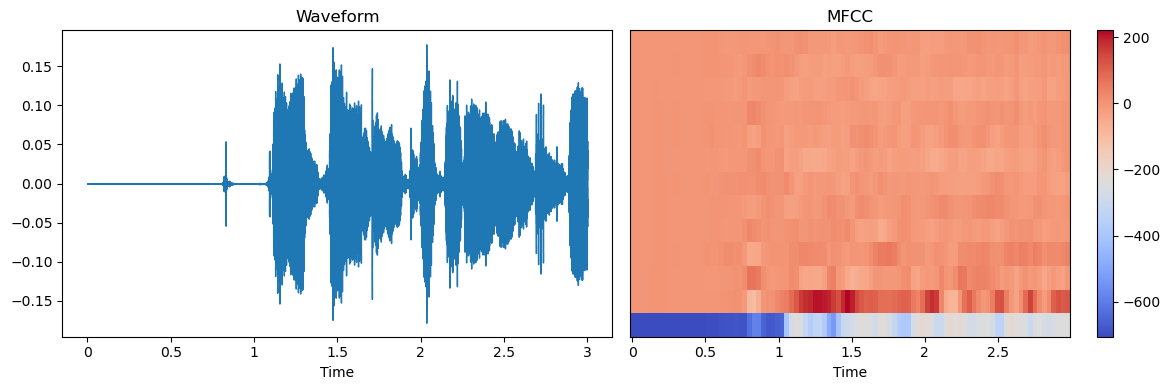

🔍 Visualizing: common_voice_en_42498922.mp3


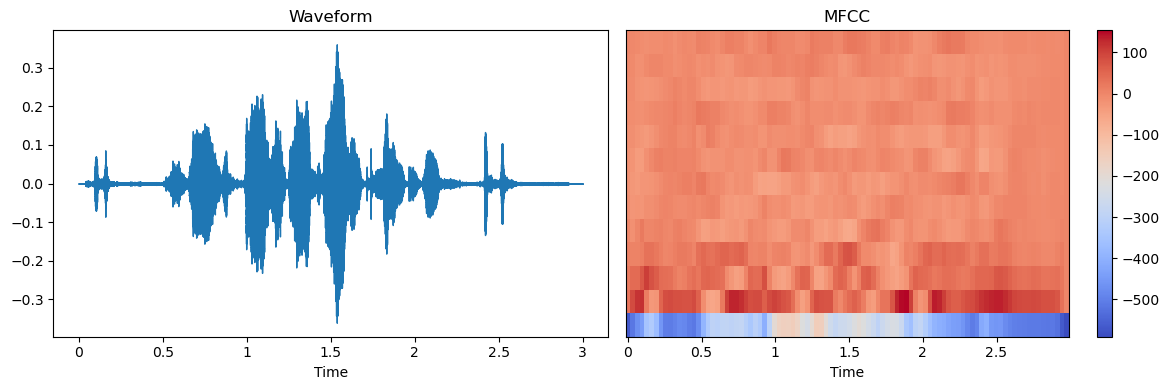

🔍 Visualizing: common_voice_en_42046273.mp3


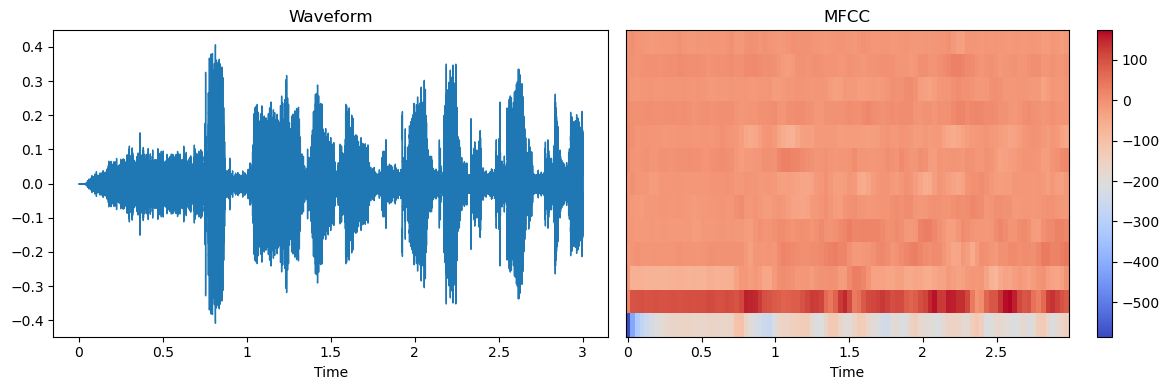

In [ ]:
# Visualization on 3 sample waveforms
sample_paths = df["path"].sample(3, random_state=42).values

for p in sample_paths:
    print(f"Visualizing: {p}")
    visualize_waveform_and_mfcc(clips_dir / p)

# PCA

In [122]:
# Flattening the MFCCs
X_flat = X.reshape((X.shape[0], -1))

In [123]:
# Fitting PCA
pca = PCA()
X_pca = pca.fit_transform(X_flat)

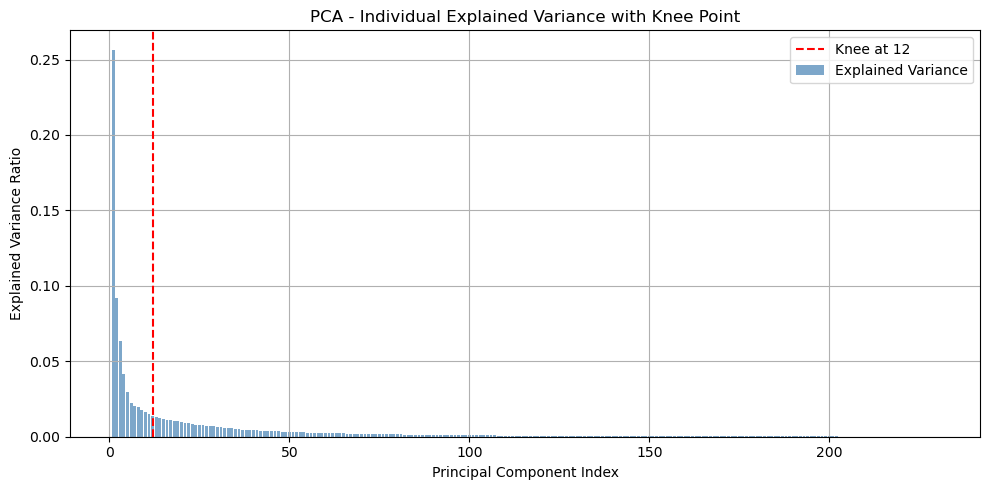

Optimal number of PCA components based on knee: 12


In [124]:
# Plotting individual explained variance
explained_var = pca.explained_variance_ratio_

# Using KneeLocator to find elbow point on individual variance
knee = KneeLocator(
    x=range(1, len(explained_var) + 1),
    y=explained_var,
    curve="convex",
    direction="decreasing"
)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, color='steelblue', label='Explained Variance')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f"Knee at {knee.knee}")
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Individual Explained Variance with Knee Point")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Optimal number of PCA components based on knee: {knee.knee}")

In [125]:
# The shape of flattened X
print(f"The shape before PCA: {X_flat.shape}")

The shape before PCA: (230, 1222)


## MFCCs were shaped like: (230 samples, 13 MFCCs, 94 time steps)
## Flattened → X_flat.shape == (230, 13 * 94) == (230, 1222)

In [126]:
# Using the number of components suggested by KneeLocator
optimal_components = knee.knee

# Applying PCA with selected number of components
pca_final = PCA(n_components=optimal_components)
X_reduced = pca_final.fit_transform(X_flat)

print(f"PCA applied. New shape: {X_reduced.shape}")

PCA applied. New shape: (230, 12)


In [128]:
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced, y_encoded, test_size=0.2, random_state=42
)

print(f"Reduced Train shape: {X_train_reduced.shape}")
print(f"Reduced Test shape: {X_test_reduced.shape}")

Reduced Train shape: (184, 12)
Reduced Test shape: (46, 12)


In [129]:
np.save(processed_dir / "X_train_reduced.npy", X_train_reduced)
np.save(processed_dir / "X_test_reduced.npy", X_test_reduced)
np.save(processed_dir / "y_train.npy", y_train)
np.save(processed_dir / "y_test.npy", y_test)

print("All reduced features and labels saved to /data/processed/")

All reduced features and labels saved to /data/processed/
